<h1>Imports and Data Initilization<h1>

In [261]:
#From https://towardsdatascience.com/cnn-sentiment-analysis-1d16b7c5a0e7
#testing https://realpython.com/python-keras-text-classification/
#https://medium.com/intuitive-deep-learning/autoencoders-neural-networks-for-unsupervised-learning-83af5f092f0b
import pandas as pd
import matplotlib.pyplot as plt
import re
from gensim import models
from gensim.models import Word2Vec
from matplotlib import pyplot
import matplotlib.pyplot as plt
from nltk.tokenize import sent_tokenize
from nltk import word_tokenize
from nltk.corpus import stopwords
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Dropout, Reshape, Flatten, concatenate, Input, Conv1D, GlobalMaxPooling1D, Embedding
from keras.models import Model
from sklearn.datasets import make_classification
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
import string
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model




temp = pd.read_csv("persuasionExamples6.csv", sep=",", encoding ='latin-1')
data = temp[temp['containsPersuasion'] == '[1]'].copy()
data

,body,containsPersuasion
0,It is disgusting. If Will had cheated on Jada ...,[1]
1,As a man in my late 50s I wish I had the halls...,[1]
2,Im just one guy. I try to be a good person; I...,[1]
3,"He was a black, retied police chief who was mu...",[1]
4,"I hate hearing people say, ""oh, he bought a Co...",[1]
...,...,...
30885,I'm going to be honest and say I haven't read ...,[1]
30886,[removed],[1]
30887,"Im sorry if I butcher this, but this is how i...",[1]
30888,It is never really necessary to assume somethi...,[1]


<h1>Tokenization<h1>

In [262]:
data['body'][0]
data['bodySentences'] = data['body'].apply(lambda x: sent_tokenize(x))
data.head()

,body,containsPersuasion,bodySentences
0,It is disgusting. If Will had cheated on Jada ...,[1],"[It is disgusting., If Will had cheated on Jad..."
1,As a man in my late 50s I wish I had the halls...,[1],[As a man in my late 50s I wish I had the hall...
2,Im just one guy. I try to be a good person; I...,[1],"[Im just one guy., I try to be a good person;..."
3,"He was a black, retied police chief who was mu...",[1],"[He was a black, retied police chief who was m..."
4,"I hate hearing people say, ""oh, he bought a Co...",[1],"[I hate hearing people say, ""oh, he bought a C..."


In [263]:
def removePunct(text):
    textNoPunct = ''
    textNoPunct = re.sub('['+string.punctuation+']', '', str(text))
    return textNoPunct

#data['Cleaned_Body'] = data['Body'].apply(lambda x:removePunct(x))
#data['Cleaned_Body'] = data['body'].apply(lambda x:removePunct(x))
data['Cleaned_Body'] = data['bodySentences'].apply(lambda x:[removePunct(i) for i in x])
data['Cleaned_Body'][0]

print(word_tokenize(x) for x in data.Cleaned_Body[0])
print(data['Cleaned_Body'][0][0])

<generator object <genexpr> at 0x000001839CDCC200>
It is disgusting


<h1>Tokenization Cleaning<h1>

In [264]:

#tokens = [[word_tokenize(sentence) for sentence in data.Cleaned_Body]

tokens = [[word_tokenize(clause) for clause in sentence] for sentence in data.Cleaned_Body]

def lowerCase(tokens):
    return [t.lower() for t in tokens]
def removeStopWords(tokens):
    return [word for word in tokens if word not in stoplist]
#lowTokens = [lowerCase(token) for token in tokens]

lowTokens = [[lowerCase(clause) for clause in token] for token in tokens] 

stoplist = stopwords.words('english')
#filteredWords = [removeStopWords(sentence) for sentence in lowTokens]
filteredWords = [[removeStopWords(clause) for clause in sentence] for sentence in lowTokens]
#data['Text_Final'] = [' '.join(sentence) for sentence in filteredWords]

data['Text_Final'] = [[' '.join(clause) for clause in sentence] for sentence in filteredWords]

data['Tokens'] = filteredWords
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30890 entries, 0 to 30889
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   body                30890 non-null  object
 1   containsPersuasion  30890 non-null  object
 2   bodySentences       30890 non-null  object
 3   Cleaned_Body        30890 non-null  object
 4   Text_Final          30890 non-null  object
 5   Tokens              30890 non-null  object
dtypes: object(6)
memory usage: 2.9+ MB


<h1>Semi-Supervised Label Construction<h1>

In [227]:
logos = []
ethos = []
pathos = []

for i in data.containsPersuasion:
    if i == -1:
        
        logos.append(0)
        pathos.append(0)
        ethos.append(0)
    if i == 1:
        logos.append(1)
        pathos.append(0)
        ethos.append(0)
    if i == 2:
        logos.append(0)
        pathos.append(1)
        ethos.append(0)
    elif i == 3:
        logos.append(0)
        pathos.append(0)
        ethos.append(1)

        
data['Logos'] = logos
data['Pathos'] = pathos
data["Ethos"] = ethos
# isRhetoric = []
# for i in data.containsPersuasion:
#     if i == 1:
#         isRhetoric.append(1)
#     else:
#         isRhetoric.append(0)

#data = data[['Text_Final', 'Tokens', 'IsRhetoric', 'Logos', 'Ethos', 'Pathos']]
data['containsPersuasion'] = isRhetoric
data = data[['Text_Final', 'Tokens', 'containsPersuasion']]
data.info()

ValueError: Length of values does not match length of index

<h2>Data-Split for semi/self supervised<h2>

In [265]:
data_train, data_test = train_test_split(data, test_size = 0.1, random_state=40)
#all_training_words = [word for tokens in data_train["Tokens"] for word in tokens]
all_training_words = [word for tokens in data["Tokens"] for word in tokens]
#all_training_words = [[word for tokens in data["Tokens"] for word in clause] for clause in tokens]
#raining_sentence_lengths = [len(tokens) for tokens in data_train["Tokens"]]
training_sentence_lengths = [len(tokens) for tokens in data["Tokens"]]
#TRAINING_VOCAB = sorted(list(set(all_training_words)))
TRAINING_VOCAB = sorted(list(set(x) for x in all_training_words))

print("%s words total, with a vocabulary size of %s" %(len(all_training_words), len(TRAINING_VOCAB)))
print("Max sentence length is %s" % max(training_sentence_lengths))



print(len(data["Tokens"]))
print(all_training_words[:5])

201410 words total, with a vocabulary size of 201410
Max sentence length is 85
30890
[['disgusting'], ['cheated', 'jada', 'entire', 'internet', 'would', 'turn', 'crucify'], ['except', 'man', 'one', 'mocked', 'memed'], ['firstly', 'dont', 'reason', 'involved', 'relationship', 'choose', 'make', 'work', 'good'], ['however', 'doesnt', 'mean', 'jada', 'proud', 'actions']]


In [269]:
#all_test_words = [word for tokens in data_test["Tokens"] for word in tokens]
#test_sentence_lengths = [len(tokens) for tokens in data_test["Tokens"]]
all_test_words = [word for tokens in data["Tokens"] for word in tokens]
test_sentence_lengths = [len(tokens) for tokens in data["Tokens"]]
#TEST_VOCAB = sorted(list(set(all_test_words)))
TEST_VOCAB = sorted(all_test_words)

print("%s words total, with vocab size of %s" % (len(all_test_words), len(TEST_VOCAB)))
print("Max sentence length is %s" % max(test_sentence_lengths))

201410 words total, with vocab size of 201410
Max sentence length is 85


<h2>Load vectorization model 
   <h2>

<h2>Pretrained Vectorized model<h2>

In [255]:
word2vec_path = 'https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz'
word2vec = models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)



<h2>Self Trained Vectorization<h2>

In [274]:
word2vec = Word2Vec(sentences=all_training_words, vector_size=100, workers=1, seed=42)


In [275]:

MAX_SEQUENCE_LENGTH = 516
EMBEDDING_DIM = 300
tokenizer = Tokenizer(num_words=len(TRAINING_VOCAB), lower = True, char_level = False)
#tokenizer.fit_on_texts(data_train["Text_Final"].tolist())
#training_sequences = tokenizer.texts_to_sequences(data_train["Text_Final"].tolist())
tokenizer.fit_on_texts(data["Text_Final"].tolist())
#training_sequences = tokenizer.texts_to_sequences(data["Text_Final"].tolist())
kmeans_training_sequences = [tokenizer.texts_to_sequences(x) for x in data["Text_Final"]]

print(training_sequences[:5])
train_word_index = tokenizer.word_index
print('Found %s unique tokens' % len(train_word_index))

#train_cnn_data = pad_sequences(training_sequences, maxlen=MAX_SEQUENCE_LENGTH)
kmeans_data = [pad_sequences(x, maxlen=MAX_SEQUENCE_LENGTH) for x in kmeans_training_sequences]


print(train_cnn_data[:5])

[[[184], [20308, 1833, 104], [96808, 167, 112], [61, 282, 31329, 833, 628, 28], [268, 330, 96, 164, 1461], [347, 76, 167], [417, 144787, 25570, 1833, 170, 825], [437]], [[167, 1122, 26906, 385], [66837, 177818, 10052, 129, 73, 69, 573, 628, 815, 259], [1541, 149428, 129, 33, 385, 385, 136, 114059, 149437, 61, 116, 385, 371, 127501, 801, 325, 160272, 211, 155865, 107105, 112, 37293], [48, 44919], [69, 270, 1311, 113, 635, 202, 1042, 385], [269, 827, 46]], [[434, 112, 742], [283, 28, 1780, 283, 254, 283, 450, 283, 28], [434, 112, 742], [590], [288], [2058, 37440, 247, 2085], [434, 529, 103, 69, 434, 807, 436], [434, 103, 169291, 971, 2085], [434, 9484], [434, 1199, 678, 439, 33775, 157202], [434, 375, 434, 112, 742], [140, 129, 62, 30075, 116, 114859, 31, 31], [158, 385, 980, 820], []], [[1901, 79400, 620, 17205, 26314], [527, 105174, 81545, 46, 165468], [28130, 152466, 26314, 213, 796, 1847, 1812, 145, 69], [140, 51002, 69, 616, 129, 151738]], [[475, 56959, 213, 129, 376, 289], [], [], 

In [276]:
print(len(training_sequences))
len(train_cnn_data)
train_cnn_data

30890


[array([[    0,     0,     0, ...,     0,     0,   184],
        [    0,     0,     0, ..., 20308,  1833,   104],
        [    0,     0,     0, ..., 96808,   167,   112],
        ...,
        [    0,     0,     0, ...,   347,    76,   167],
        [    0,     0,     0, ...,  1833,   170,   825],
        [    0,     0,     0, ...,     0,     0,   437]]),
 array([[     0,      0,      0, ...,   1122,  26906,    385],
        [     0,      0,      0, ...,    628,    815,    259],
        [     0,      0,      0, ..., 107105,    112,  37293],
        [     0,      0,      0, ...,      0,     48,  44919],
        [     0,      0,      0, ...,    202,   1042,    385],
        [     0,      0,      0, ...,    269,    827,     46]]),
 array([[     0,      0,      0, ...,    434,    112,    742],
        [     0,      0,      0, ...,    450,    283,     28],
        [     0,      0,      0, ...,    434,    112,    742],
        ...,
        [     0,      0,      0, ..., 114859,     31,     31]

In [277]:


train_embedding_weights = np.zeros((len(train_word_index)+1, EMBEDDING_DIM))

for word, index in train_word_index.items():
    train_embedding_weights[index,:] = word2vec[word] if word in word2vec else np.random.rand(EMBEDDING_DIM)
    
print(train_embedding_weights.shape)
print(len(train_word_index.items()))


TypeError: argument of type 'Word2Vec' is not iterable

In [273]:
test_sequences = tokenizer.texts_to_sequences(data_test["Text_Final"].tolist())
test_cnn_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
len(test_sequences)

3089

In [22]:

def ConvNet(embeddings, max_sequence_length, num_words, embedding_dim, labels_index):
    
    embedding_layer = Embedding(num_words, embedding_dim, weights=[embeddings], input_length = max_sequence_length, trainable=False)
    
    sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    
    convs = []
    filter_sizes = [2,3,4,5,6]
    
    for filter_size in filter_sizes:
        l_conv = Conv1D(filters = 200, kernel_size=filter_size, activation = 'relu')(embedded_sequences)
        l_pool = GlobalMaxPooling1D()(l_conv)
        convs.append(l_pool)
        
    l_merge = concatenate(convs, axis = 1)
    
    x = Dropout(0.1)(l_merge)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    preds = Dense(labels_index, activation ='sigmoid')(x)
    
    model = Model(sequence_input, preds)
    model.compile(loss ='binary_crossentropy', optimizer = 'adam', metrics = ['acc'])
    model.summary()
    return model
    

In [ ]:
#label_names = ['Logos', 'Ethos', 'Pathos']
label_names = ['containsPersuasion']
y_train = data_train[label_names].values
x_train = train_cnn_data
y_tr = y_train

model = ConvNet(train_embedding_weights, MAX_SEQUENCE_LENGTH, len(train_word_index)+1, EMBEDDING_DIM, len(list(label_names)))


In [15]:
num_epochs = 1
batch_size = 34

hist = model.fit(x_train, y_tr, epochs=num_epochs, validation_split=0.1, shuffle=True, batch_size=batch_size)

Train on 63335 samples, validate on 7038 samples
Epoch 1/2
63335/63335 [==============================] - 1516s 24ms/step - loss: 0.0035 - acc: 0.9978 - val_loss: 2.1929e-04 - val_acc: 1.0000
Epoch 2/2
63335/63335 [==============================] - 1554s 25ms/step - loss: 6.5896e-05 - acc: 1.0000 - val_loss: 7.7896e-05 - val_acc: 1.0000


In [16]:
predictions = model.predict(test_cnn_data, batch_size=1024, verbose = 1)

7820/7820 [==============================] - 70s 9ms/step


In [17]:
#labels = [1, 0, -1]
labels = [0, 1]
prediction_labels = []
for p in predictions:
    prediction_labels.append(labels[np.argmax(p)])

#sum(data_test.IsRhetoric==prediction_labels)/len(prediction_labels)
sum(data_test.containsPersuasion==prediction_labels)/len(prediction_labels)

1.0

In [18]:
#data_test.IsRhetoric
data_test.containsPersuasion

77394    0
41789    0
7067     0
25360    0
66851    0
        ..
64182    0
72670    0
58514    0
21212    0
10977    0
Name: containsPersuasion, Length: 7820, dtype: int64

In [19]:
###UNSUPERVISED
# Guide used: https://machinelearningmastery.com/autoencoder-for-classification/ 
# I am attempting to follow a tutorial for training an encoder which 
#    from my understanding will allow the feature extraction neccessary for 
#    for unsupervised use
#    Currently not addapted to our datasets

In [37]:

#X, y = make_classification(n_samples=1000, n_features=100, n_informative = 10, n_redundant=90, random_state=1)
#n_inputs = X.shape[1]
# print(X.shape, y.shape)
# print(X)
# print(y)

# data = pd.read_csv("persuasionExamples6.csv", sep=",", encoding ='latin-1')
# pers = data.loc[data["containsPersuasion"] == '[1]']
# pers
X, y = train_test_split(train_embedding_weights, test_size = 0.1, random_state=40)
# y = pers['containsPersuasion']
n_inputs = X.shape[0]
train_embedding_weights.shape

(148013, 300)

In [71]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state=1)
X_train, X_test = train_test_split(train_embedding_weights, test_size = 0.33, random_state=40)
t = MinMaxScaler()
t.fit(X_train)
X_train = t.transform(X_train)
X_test = t.transform(X_test)
print(X_train.shape)


(99168, 300)


<h2>Encoder/Decoder Section for feature extraction<h2>

In [74]:
#Encoder

visible = Input(shape=(n_inputs,))
    #Level 1
# e = Dense(n_inputs * 2)(visible)
e = Dense(n_inputs)(visible)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
    #Level 2
e = Dense(n_inputs)(e)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
    #Bottleneck Layer
n_bottleneck = n_inputs
bottleneck = Dense(n_bottleneck)(e)

Tensor("input_12:0", shape=(None, 133211), dtype=float32)


ResourceExhaustedError: OOM when allocating tensor with shape[133211,133211] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu [Op:RandomUniform]

In [56]:
# Decoder
    #Level 1
d = Dense(n_inputs)(bottleneck)
d = BatchNormalization()(d)
d = LeakyReLU()(d)
    #Level 2
d = Dense(n_inputs * 2)(d)
d = BatchNormalization()(d)
d = LeakyReLU()(d)
    #Output layer
output = Dense(n_inputs, activation = 'linear')(d)

model = Model(inputs= visible, outputs = output)

In [57]:

model.compile(optimizer = 'adam', loss='mse')
plot_model(model, 'autoencoder_no_compress.png', show_shapes=True)

history = model.fit(X_train, X_train, epochs=200, batch_size=16, verbose=2, validation_data=(X_test, X_test))



Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.
Epoch 1/200
42/42 - 0s - loss: 0.2468 - val_loss: 0.1827
Epoch 2/200
42/42 - 0s - loss: 0.0413 - val_loss: 0.1167
Epoch 3/200
42/42 - 0s - loss: 0.0256 - val_loss: 0.0681
Epoch 4/200
42/42 - 0s - loss: 0.0201 - val_loss: 0.0368
Epoch 5/200
42/42 - 0s - loss: 0.0172 - val_loss: 0.0252
Epoch 6/200
42/42 - 0s - loss: 0.0148 - val_loss: 0.0158
Epoch 7/200
42/42 - 0s - loss: 0.0136 - val_loss: 0.0116
Epoch 8/200
42/42 - 0s - loss: 0.0124 - val_loss: 0.0087
Epoch 9/200
42/42 - 0s - loss: 0.0121 - val_loss: 0.0078
Epoch 10/200
42/42 - 0s - loss: 0.0109 - val_loss: 0.0069
Epoch 11/200
42/42 - 0s - loss: 0.0106 - val_loss: 0.0067
Epoch 12/200
42/42 - 0s - loss: 0.0095 - val_loss: 0.0056
Epoch 13/200
42/42 - 0s - loss: 0.0092 - val_loss: 0.0060
Epoch 14/200
42/42 - 0s - loss: 0.0092 - val_loss: 0.0052
Epoch 15/200
42/42 - 0s - loss: 0.0088 - val_loss: 0.0051
Epoch 16/200
42/42 - 0s - loss: 0.0088 - val_loss: 0.

Epoch 141/200
42/42 - 0s - loss: 0.0041 - val_loss: 0.0021
Epoch 142/200
42/42 - 0s - loss: 0.0035 - val_loss: 0.0014
Epoch 143/200
42/42 - 0s - loss: 0.0036 - val_loss: 0.0013
Epoch 144/200
42/42 - 0s - loss: 0.0038 - val_loss: 0.0021
Epoch 145/200
42/42 - 0s - loss: 0.0040 - val_loss: 0.0020
Epoch 146/200
42/42 - 0s - loss: 0.0038 - val_loss: 0.0015
Epoch 147/200
42/42 - 0s - loss: 0.0036 - val_loss: 0.0017
Epoch 148/200
42/42 - 0s - loss: 0.0035 - val_loss: 0.0017
Epoch 149/200
42/42 - 0s - loss: 0.0037 - val_loss: 0.0017
Epoch 150/200
42/42 - 0s - loss: 0.0035 - val_loss: 0.0016
Epoch 151/200
42/42 - 0s - loss: 0.0036 - val_loss: 0.0018
Epoch 152/200
42/42 - 0s - loss: 0.0033 - val_loss: 0.0016
Epoch 153/200
42/42 - 0s - loss: 0.0036 - val_loss: 0.0014
Epoch 154/200
42/42 - 0s - loss: 0.0036 - val_loss: 0.0018
Epoch 155/200
42/42 - 0s - loss: 0.0033 - val_loss: 0.0012
Epoch 156/200
42/42 - 0s - loss: 0.0034 - val_loss: 0.0013
Epoch 157/200
42/42 - 0s - loss: 0.0036 - val_loss: 0.00

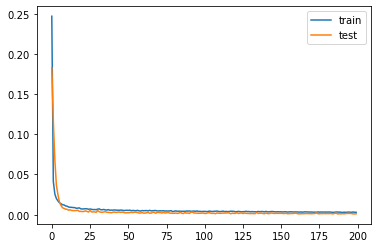

In [58]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label = 'test')

pyplot.legend()
pyplot.show()

In [23]:
#Saving encoder
encoder = Model(inputs=visible, outputs=bottleneck)
plot_model(encoder, 'encoder_no_compress.png', show_shapes=True)
encoder.save('encoder.h5')

NameError: name 'visible' is not defined

<h1>K-means<h1>
    <h2>3 Cluster<h2>

In [244]:
#print(train_cnn_data[:5])
print(len(train_cnn_data))
filtered_kmeans_data = list()
labelList = list()
count = 0
for i in train_cnn_data:
    for j in i:
        labelList.append(count)
    count +=1

    
print(type(kmeans_data[:5]))
for i in kmeans_data:
    for j in i:
        filtered_kmeans_data.append(j)
        
print(filtered_kmeans_data[:5])

30890
<class 'list'>
[array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0, 

In [245]:

#X = train_cnn_data
X = filtered_cnn_data
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)


In [167]:
print(len(kmeans.labels_))
print(kmeans.labels_[:5])
for i in range(10):
    print(data.iloc[i])


201410
[1 1 1 1 1]
body                  It is disgusting. If Will had cheated on Jada ...
containsPersuasion                                                  [1]
Cleaned_Body          [It is disgusting, If Will had cheated on Jada...
Text_Final            [disgusting, cheated jada entire internet woul...
Tokens                [[disgusting], [cheated, jada, entire, interne...
rhetoricType                                                          1
bodySentences         [It is disgusting., If Will had cheated on Jad...
Name: 0, dtype: object
body                  As a man in my late 50s I wish I had the halls...
containsPersuasion                                                  [1]
Cleaned_Body          [As a man in my late 50s I wish I had the hall...
Text_Final            [man late 50s wish halls walk job younger, sta...
Tokens                [[man, late, 50s, wish, halls, walk, job, youn...
rhetoricType                                                          1
bodySentences         

In [165]:
count1 = 0
count2 = 0
count3 = 0
for i in kmeans.labels_:
    if i == 0:
        count1 +=1 
    if i == 1:
        count2 +=1
    if i == 2:
        count3 += 1
print(count1)
print(count2)
print(count3)

28343
150606
22461


In [190]:
labels = kmeans.labels_
numPosts = len(train_cnn_data)
labelList
tupleList = list()
for i in range(len(labels)):
    tupleList.append((labels[i], labelList[i]))
solMatrix = np.zeros((numPosts, 3))
print(solMatrix.shape)
index = 0
for i in tupleList:
    if index == i[1]: 
        if i[0] == 0:
            solMatrix[index][0]+=1
        elif i[0] == 1:
            solMatrix[index][1]+=1
        elif i[0] == 2:
            solMatrix[index][2]+=1
    else:
        index += 1
        if i[0] == 0:
            solMatrix[index][0]+=1
        elif i[0] == 1:
            solMatrix[index][1]+=1
        elif i[0] == 2:
            solMatrix[index][2]+=1

print(solMatrix)
    

(30890, 3)
[[ 0.  8.  0.]
 [ 0.  6.  0.]
 [ 1. 13.  0.]
 ...
 [ 4. 25.  1.]
 [ 1. 10.  0.]
 [ 6. 12.  3.]]


In [191]:
data
data['Classification-0'] = -1
data['Classification-1'] = -1
data['Classification-2'] = -1

count = 0
for i, row in data.iterrows():
    if row['containsPersuasion'] == '[1]':
        data.at[i, 'Classification-0'] = solMatrix[count][0]
        data.at[i, 'Classification-1'] = solMatrix[count][1]
        data.at[i, 'Classification-2'] = solMatrix[count][2]

        count+=1

data

,body,containsPersuasion,Cleaned_Body,Text_Final,Tokens,rhetoricType,bodySentences,Classification-0,Classification-1,Classification-2
0,It is disgusting. If Will had cheated on Jada ...,[1],"[It is disgusting, If Will had cheated on Jada...","[disgusting, cheated jada entire internet woul...","[[disgusting], [cheated, jada, entire, interne...",1,"[It is disgusting., If Will had cheated on Jad...",0,8,0
1,As a man in my late 50s I wish I had the halls...,[1],[As a man in my late 50s I wish I had the hall...,"[man late 50s wish halls walk job younger, sta...","[[man, late, 50s, wish, halls, walk, job, youn...",1,[As a man in my late 50s I wish I had the hall...,0,6,0
2,Im just one guy. I try to be a good person; I...,[1],"[Im just one guy, I try to be a good person I...","[im one guy, try good person try treat everyo...","[[im, one, guy], [try, good, person, try, tre...",1,"[Im just one guy., I try to be a good person;...",1,13,0
3,"He was a black, retied police chief who was mu...",[1],[He was a black retied police chief who was mu...,[black retied police chief murdered protests t...,"[[black, retied, police, chief, murdered, prot...",1,"[He was a black, retied police chief who was m...",2,2,0
4,"I hate hearing people say, ""oh, he bought a Co...",[1],[I hate hearing people say oh he bought a Corv...,[hate hearing people say oh bought corvette he...,"[[hate, hearing, people, say, oh, bought, corv...",1,"[I hate hearing people say, ""oh, he bought a C...",0,13,3
...,...,...,...,...,...,...,...,...,...,...
30885,I'm going to be honest and say I haven't read ...,[1],[Im going to be honest and say I havent read t...,[im going honest say havent read myriad replie...,"[[im, going, honest, say, havent, read, myriad...",1,[I'm going to be honest and say I haven't read...,1,5,1
30886,[removed],[1],[removed],[removed],[[removed]],1,[[removed]],0,1,0
30887,"Im sorry if I butcher this, but this is how i...",[1],[Im sorry if I butcher this but this is how i...,"[im sorry butcher explained, its reinforcing...","[[im, sorry, butcher, explained], [its, rein...",1,"[Im sorry if I butcher this, but this is how ...",4,25,1
30888,It is never really necessary to assume somethi...,[1],[It is never really necessary to assume someth...,[never really necessary assume something someo...,"[[never, really, necessary, assume, something,...",1,[It is never really necessary to assume someth...,1,10,0


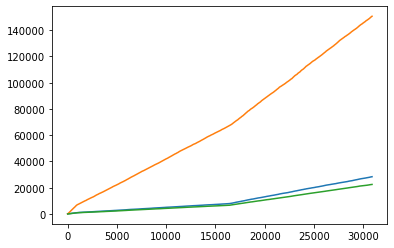

In [211]:
class0, class1, class2 = list(), list(), list()
sum0, sum1, sum2 = 0,0,0
for index, row in data.iterrows():
    sum0 += row['Classification-0']
    class0.append(sum0)
    
    sum1 += row["Classification-1"]
    class1.append(sum1)
    
    sum2 += row["Classification-2"]
    class2.append(sum2)
plt.plot(class0)
plt.plot(class1)
plt.plot(class2)
plt.show()

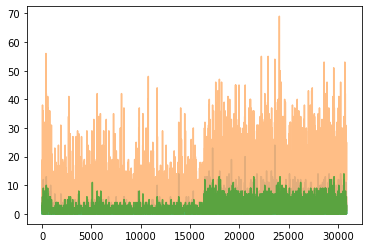

In [221]:
class0, class1, class2 = list(), list(), list()
sum0, sum1, sum2 = 0,0,0
for index, row in data.iterrows():
    sum0 = row['Classification-0']
    class0.append(sum0)
    
    sum1 = row["Classification-1"]
    class1.append(sum1)
    
    sum2 = row["Classification-2"]
    class2.append(sum2)
plt.plot(class0, alpha=0.25)
plt.plot(class1, alpha=0.5)
plt.plot(class2, alpha=0.5)
plt.show()

<h2>4 Cluster<h2>

In [228]:
X = filtered_cnn_data
kmeans = KMeans(n_clusters=4, random_state=0).fit(X)
count1 = 0
count2 = 0
count3 = 0
count4 = 0 
for i in kmeans.labels_:
    if i == 0:
        count1 +=1 
    if i == 1:
        count2 +=1
    if i == 2:
        count3 += 1
    if i == 3:
        count4 +=1
print(count1)
print(count2)
print(count3)
print(count4)

25889
138056
16833
20632


In [229]:
labels = kmeans.labels_
numPosts = len(train_cnn_data)
labelList
tupleList = list()
for i in range(len(labels)):
    tupleList.append((labels[i], labelList[i]))
solMatrix = np.zeros((numPosts, 4))
print(solMatrix.shape)
index = 0
for i in tupleList:
    if index == i[1]: 
        if i[0] == 0:
            solMatrix[index][0]+=1
        elif i[0] == 1:
            solMatrix[index][1]+=1
        elif i[0] == 2:
            solMatrix[index][2]+=1
        elif i[0] == 3:
            solMatrix[index][3]+=1
    else:
        index += 1
        if i[0] == 0:
            solMatrix[index][0]+=1
        elif i[0] == 1:
            solMatrix[index][1]+=1
        elif i[0] == 2:
            solMatrix[index][2]+=1
        elif i[0] == 3:
            solMatrix[index][3]+=1
            
data['Classification-0'] = -1
data['Classification-1'] = -1
data['Classification-2'] = -1
data['Classification-3'] = -1


count = 0
for i, row in data.iterrows():
    if row['containsPersuasion'] == '[1]':
        data.at[i, 'Classification-0'] = solMatrix[count][0]
        data.at[i, 'Classification-1'] = solMatrix[count][1]
        data.at[i, 'Classification-2'] = solMatrix[count][2]
        data.at[i, 'Classification-3'] = solMatrix[count][3]
        count+=1

data

(30890, 4)


,body,containsPersuasion,Classification-0,Classification-1,Classification-2,Classification-3
0,It is disgusting. If Will had cheated on Jada ...,[1],0,7,1,0
1,As a man in my late 50s I wish I had the halls...,[1],0,5,1,0
2,Im just one guy. I try to be a good person; I...,[1],1,11,2,0
3,"He was a black, retied police chief who was mu...",[1],2,2,0,0
4,"I hate hearing people say, ""oh, he bought a Co...",[1],0,10,5,1
...,...,...,...,...,...,...
30885,I'm going to be honest and say I haven't read ...,[1],1,5,0,1
30886,[removed],[1],0,1,0,0
30887,"Im sorry if I butcher this, but this is how i...",[1],4,23,2,1
30888,It is never really necessary to assume somethi...,[1],1,9,1,0


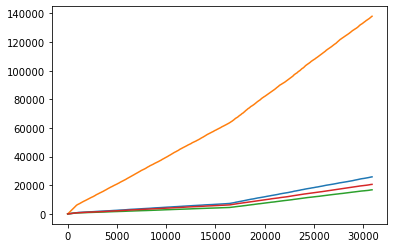

In [230]:
class0, class1, class2, class3= list(), list(), list(), list()
sum0, sum1, sum2, sum3 = 0,0,0, 0
for index, row in data.iterrows():
    sum0 += row['Classification-0']
    class0.append(sum0)
    
    sum1 += row["Classification-1"]
    class1.append(sum1)
    
    sum2 += row["Classification-2"]
    class2.append(sum2)
    
    sum3 += row["Classification-3"]
    class3.append(sum3)
plt.plot(class0)
plt.plot(class1)
plt.plot(class2)
plt.plot(class3)

plt.show()

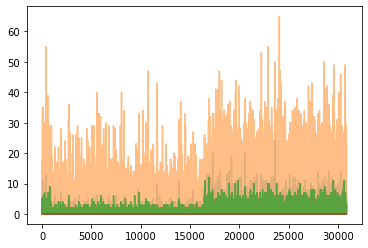

In [231]:
class0, class1, class2, class3 = list(), list(), list(), list()
sum0, sum1, sum2, sum3 = 0,0,0, 0
for index, row in data.iterrows():
    sum0 = row['Classification-0']
    class0.append(sum0)
    
    sum1 = row["Classification-1"]
    class1.append(sum1)
    
    sum2 = row["Classification-2"]
    class2.append(sum2)
    
    sum2 = row["Classification-3"]
    class3.append(sum3)
plt.plot(class0, alpha=0.25)
plt.plot(class1, alpha=0.5)
plt.plot(class2, alpha=0.75)
plt.plot(class3, alpha=0.9)

plt.show()